<a href="https://colab.research.google.com/github/ravadhani/NLP/blob/main/SummarizationUsingLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Case Study : Inshorts (News app)

**Topic:** Text Summarization using RNN (Recurrent Neural Networks)


**Problem statement:**
Try to summarize the news articles which are 40-60 words in less than 30 words.


In [3]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=f6c3a6de466d417daf510834b16f1568e9328c874d6429261f9fb069da80b84b
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [4]:
import pandas as pd
import numpy as np
import spacy
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from rouge_score import rouge_scorer

In [5]:
#setting up the configuration parameters

config = {
    'min_text_len' : 40,
    'max_text_len' : 60,
    'max_summary_len' : 30,
    'latent_dim' : 300,
    'embedding_dim' : 200
}

Loading the dataset

In [7]:
!gdown 1sui9RXxVsPDa4s2kooQwRGhb8taZhcgD
!gdown 1H3gdo7SLBiWE_GGD6_xcdAp2wJJFcd5L

Downloading...
From: https://drive.google.com/uc?id=1sui9RXxVsPDa4s2kooQwRGhb8taZhcgD
To: /content/news_summary.csv
100% 11.9M/11.9M [00:00<00:00, 33.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1H3gdo7SLBiWE_GGD6_xcdAp2wJJFcd5L
To: /content/news_summary_more.csv
100% 41.4M/41.4M [00:01<00:00, 35.0MB/s]


In [8]:
summary = pd.read_csv('news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [7]:
raw.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [8]:
summary.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [9]:
# renaming the columns from both dataframes to same name
raw = raw.rename(columns = {'headlines':'summary'})
summary = summary[['headlines', 'text']].rename(columns = {'headlines':'summary'})

In [10]:
#Concatenate the summary and the raw files
df = pd.concat([raw, summary]).reset_index(drop=True)

summary.shape, raw.shape

((4514, 2), (98401, 2))

Distribution of words

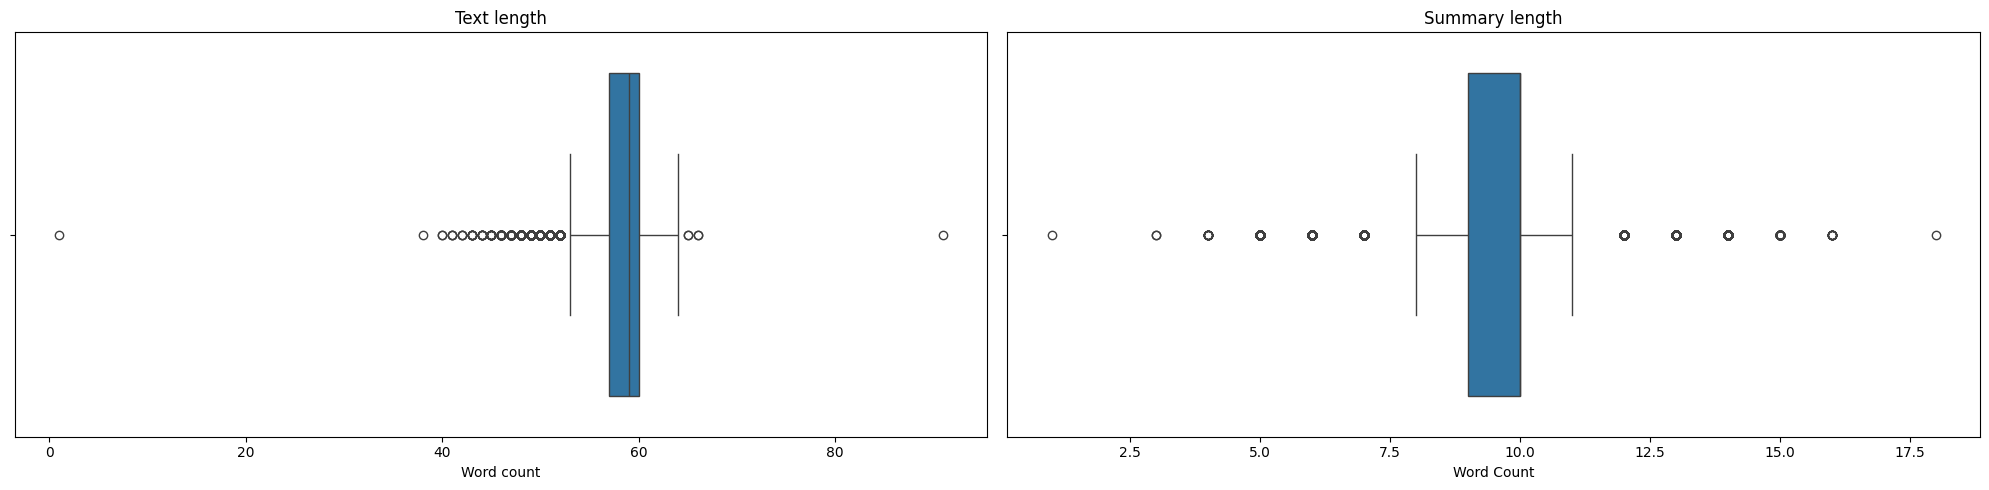

In [11]:
fig, ax = plt.subplots(1,2, figsize=(20, 5))

sns.boxplot(raw.text.str.split().str.len(),  orient='h', ax=ax[0])
ax[0].set_title('Text length')
ax[0].set_xlabel('Word count')
ax[0].set_ylabel('')

sns.boxplot(raw.summary.str.split().str.len(), orient='h',ax=ax[1])
ax[1].set_title('Summary length')
ax[1].set_xlabel('Word Count')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

Filter text in the range between 40 and 60 words

In [12]:
print(f'Before filtering: {df.shape}')
pre = df.loc[((df['text'].str.split(" ").str.len() > config['min_text_len'])
              &(df['text'].str.split(" ").str.len() < config['max_text_len']))].reset_index(drop=True)
print(f'After filtering: {pre.shape}')

Before filtering: (102915, 2)
After filtering: (54572, 2)


Distribution of words after filtering

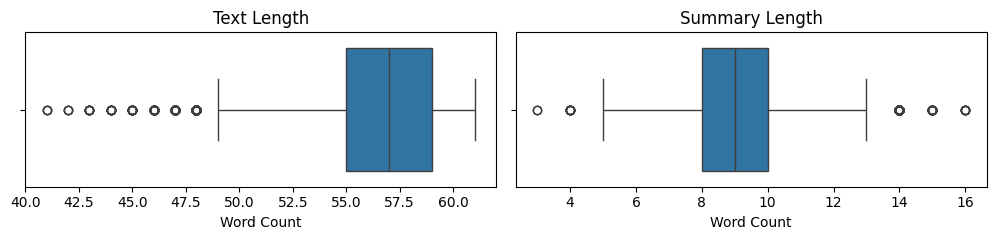

In [13]:

# Create subplots with the desired layout and size
fig, ax = plt.subplots(1, 2, figsize=(10, 2.5))

# Plot horizontal boxplot for text length
sns.boxplot(pre.text.str.split().str.len(), orient='h', ax=ax[0])
ax[0].set_title('Text Length')  # Set title for the text length plot
ax[0].set_xlabel('Word Count')  # Set x-axis label for the text length plot
ax[0].set_ylabel('')  # Clear y-axis label (no need for y-axis label in this orientation)

# Plot horizontal boxplot for summary length
sns.boxplot(pre.summary.str.split().str.len(), orient='h', ax=ax[1])
ax[1].set_title('Summary Length')  # Set title for the summary length plot
ax[1].set_xlabel('Word Count')  # Set x-axis label for the summary length plot
ax[1].set_ylabel('')  # Clear y-axis label (no need for y-axis label in this orientation)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


Let's look at a sample

In [14]:
idx = 1
print(f'Text: {pre.text[idx]}')
print()
print(f'Summary: {pre.summary[idx]}')
print()
print(f'Text length: {len(pre.text[idx].split())}')
print(f'Summary length: {len(pre.summary[idx].split())}')

Text: India recorded their lowest ODI total in New Zealand after getting all out for 92 runs in 30.5 overs in the fourth ODI at Hamilton on Thursday. Seven of India's batsmen were dismissed for single-digit scores, while their number ten batsman Yuzvendra Chahal top-scored with 18*(37). India's previous lowest ODI total in New Zealand was 108.

Summary: India get all out for 92, their lowest ODI total in New Zealand

Text length: 56
Summary length: 13


#We can use a Many to Many RNN architecture here, as it has multiple input and multiple output.

In [16]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [16]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 25.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, InputLayer, RNN, SimpleRNN, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

import string
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split

import spacy
from time import time
import numpy as np

**Text Preprocessing**

In [18]:
import re

#remove non-alphabetic characters (Data Cleaning)
def text_strip(sentence):
  pattern = r'[\t\r\n]'
  sentence = re.sub(pattern, ' ', str(sentence)).lower()

  #remove - if it occurs more than one time consecutively
  sentence = re.sub(r'-{2,}', ' ', str(sentence)).lower()

  #remove . if it occurs more than one time consecutively
  sentence = re.sub(r'\.{2,}', ' ', str(sentence)).lower()

  #remove the characters <>()|&©ø"',;?~*!
  sentence = re.sub(r'[<>()|&©ø\[\]\'\",;?~*!]', ' ', str(sentence)).lower()

  #remove \x9* in text
  sentence = re.sub(r'(\\x9\d)', ' ', str(sentence)).lower()

  #replace CM# and CHG# to CM_NUM
  sentence = re.sub('([cC][mM]\d+)|([cC][hH][gG]\d+)', 'CM_NUM', str(sentence)).lower()

  #remove punctuations at the end of a word
  sentence = re.sub(r'\.\s+', ' ', str(sentence)).lower()
  sentence = re.sub(r'\-\s+', ' ', str(sentence)).lower()
  sentence = re.sub(r'\:\s+', ' ', str(sentence)).lower()

  #remove multiple spaces
  sentence = re.sub('\s+', ' ', str(sentence)).lower()

  return sentence


Clean the text and add the 'start' and 'end; tokens

In [19]:
pre['cleaned_text'] = pre.text.apply(lambda x: text_strip(x))
pre['cleaned_summary'] = pre.summary.apply(lambda x: '_START_ '+ text_strip(x) + ' _END_')
pre['cleaned_summary'] = pre['cleaned_summary'].apply(lambda x: 'sostok ' + x + ' eostok')
pre.head()

,summary,text,cleaned_text,cleaned_summary
0,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan has deni...,sostok _START_ rahat fateh ali khan denies get...
1,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...,india recorded their lowest odi total in new z...,sostok _START_ india get all out for 92 their ...
2,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...,andhra pradesh cm n chandrababu naidu has said...,sostok _START_ called pm modi sir 10 times to ...
3,81-yr-old woman conducts physical training in ...,"Isha Ghosh, an 81-year-old member of Bharat Sc...",isha ghosh an 81-year-old member of bharat sco...,sostok _START_ 81-yr-old woman conducts physic...
4,"Karan Johar, Tabu turn showstoppers on opening...",Filmmaker Karan Johar and actress Tabu turned ...,filmmaker karan johar and actress tabu turned ...,sostok _START_ karan johar tabu turn showstopp...


In [20]:
print(pre.shape)
post_pre = pre[((pre.cleaned_text.str.split().str.len() <= config['max_text_len']) &
                (pre.cleaned_summary.str.split().str.len() <= (config['max_summary_len']+4)))].copy()

post_pre = post_pre.reset_index(drop=True)
print(post_pre.shape)

post_pre = post_pre.drop(['text', 'summary'], axis=1)
post_pre = post_pre.rename(columns = {'cleaned_text':'text',
                                      'cleaned_summary':'summary'})
post_pre.head()

(54572, 4)
(47500, 4)


,text,summary
0,pakistani singer rahat fateh ali khan has deni...,sostok _START_ rahat fateh ali khan denies get...
1,india recorded their lowest odi total in new z...,sostok _START_ india get all out for 92 their ...
2,andhra pradesh cm n chandrababu naidu has said...,sostok _START_ called pm modi sir 10 times to ...
3,isha ghosh an 81-year-old member of bharat sco...,sostok _START_ 81-yr-old woman conducts physic...
4,filmmaker karan johar and actress tabu turned ...,sostok _START_ karan johar tabu turn showstopp...


Split the data into train and validation sets

In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(np.array(post_pre['text']),
                                                      np.array(post_pre['summary']),
                                                      test_size=0.1,
                                                      random_state=0,
                                                      shuffle=True
                                                      )
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((42750,), (4750,), (42750,), (4750,))

In [22]:
def get_rare_words(text_col):
  text_tokenizer = Tokenizer()
  text_tokenizer.fit_on_texts(list(text_col))

  threshold = 5
  cnt = 0
  tot_cnt = 0

  for key, value in text_tokenizer.word_counts.items():
    tot_cnt += 1
    if value < threshold:
      cnt += 1

  print("% of rare words in vocabulary: ", (cnt/tot_cnt) * 100)

  return cnt, tot_cnt


Getting the counts of rare words and all words in the training data

In [23]:
x_train_rare_word_cnt, x_train_all_word_cnt = get_rare_words(text_col = x_train)
print("Number of rare words in the training dataset: ",x_train_rare_word_cnt)
print("Total number of words in the training dataset: ", x_train_all_word_cnt)

% of rare words in vocabulary:  64.22363847045192
Number of rare words in the training dataset:  37689
Total number of words in the training dataset:  58684


We are going to Tokenize the train set without the rare words. So we can give num_words as the total number of words excluding the rare words.
Tokenizer internally indexes the words based on their word count in descending order. So when num_words is given automatically the rare words are excluded.

In [24]:
#prepare tokenizer - not considering the rare words this time.
x_tokenizer = Tokenizer(num_words = x_train_all_word_cnt - x_train_rare_word_cnt)
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequence to integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_train)
x_val_seq = x_tokenizer.texts_to_sequences(x_valid)

#pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq, maxlen=config['max_text_len'], padding='post')
x_val = pad_sequences(x_val_seq, maxlen=config['max_text_len'], padding='post')

#size of the vocabulary = total tokens + 1 token for padding
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))


Size of vocabulary in X = 20996


Tokenize y_train and y_valid data sets

In [25]:
y_train_rare_word_cnt, y_train_all_word_cnt = get_rare_words(text_col = y_train)
print("Number of rare words in the training dataset of Y: ",y_train_rare_word_cnt)
print("Total number of words in the training dataset of Y: ", y_train_all_word_cnt)

% of rare words in vocabulary:  66.49736426949863
Number of rare words in the training dataset of Y:  17282
Total number of words in the training dataset of Y:  25989


In [26]:
#prepare a tokenizer - not considering the rare words.
y_tokenizer = Tokenizer(num_words = y_train_all_word_cnt - y_train_rare_word_cnt)
y_tokenizer.fit_on_texts(list(y_train))

#convert tokens to integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_valid)

#pad zeros upto max length
y_tr = pad_sequences(y_tr_seq, maxlen = config['max_summary_len'], padding = 'post')
y_val = pad_sequences(y_val_seq, maxlen = config['max_summary_len'], padding = 'post')

#size of the vocabulary = total tokens + 1 token for padding
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))


Size of vocabulary in Y = 8708


**Initializing Encoder - Decoder architecture**

In [27]:
latent_dim = config['latent_dim']
embedding_dim = config['embedding_dim']
max_text_len = config['max_text_len']
max_summary_len = config['max_summary_len']

#Encoder
encoder_inputs = Input(shape=(max_text_len,))
#embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable = True)(encoder_inputs)

#encoder LSTM1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 =  encoder_lstm1(enc_emb)

#encoder LSTM2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder LSTM3
encoder_lstm3 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

#set up the decoder using encoder_states as the initial state
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

#define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 60, 200)              4199200   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 60, 300),            601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

**Compile and Train the model**

In [28]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_name = "./model.weights.h5"
save_model = tf.keras.callbacks.ModelCheckpoint(filepath=model_name,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [29]:
history = model.fit(
            [x_tr, y_tr[:, :-1]],
            y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
            epochs = 500,
            callbacks = [es, save_model],
            batch_size = 1024,
            validation_data = ([x_val, y_val[:, :-1]],
                               y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]),
          )

Epoch 1/500
42/42 [==============================] - ETA: 0s - loss: 4.4714 - accuracy: 0.5848
Epoch 1: val_loss improved from inf to 2.78774, saving model to ./model.weights.h5
42/42 [==============================] - 84s 2s/step - loss: 4.4714 - accuracy: 0.5848 - val_loss: 2.7877 - val_accuracy: 0.6204
Epoch 2/500
42/42 [==============================] - ETA: 0s - loss: 2.7627 - accuracy: 0.6185
Epoch 2: val_loss did not improve from 2.78774
42/42 [==============================] - 64s 2s/step - loss: 2.7627 - accuracy: 0.6185 - val_loss: 2.8197 - val_accuracy: 0.6181
Epoch 3/500
42/42 [==============================] - ETA: 0s - loss: 2.6793 - accuracy: 0.6437
Epoch 3: val_loss improved from 2.78774 to 2.50708, saving model to ./model.weights.h5
42/42 [==============================] - 62s 1s/step - loss: 2.6793 - accuracy: 0.6437 - val_loss: 2.5071 - val_accuracy: 0.6857
Epoch 4/500
42/42 [==============================] - ETA: 0s - loss: 2.4879 - accuracy: 0.6883
Epoch 4: val_los

As we can see the above training has stopped due to early stopping.
Plotting the train loss and validation loss

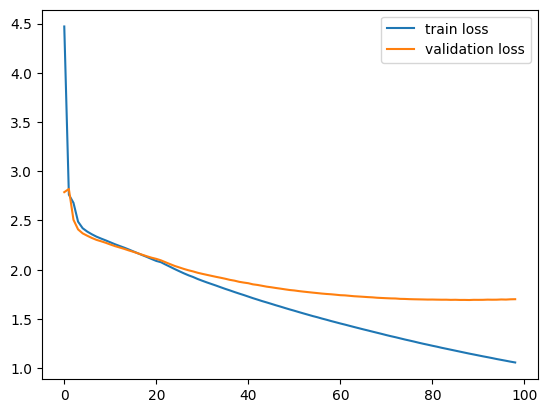

In [31]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='validation loss')
pyplot.legend()
pyplot.show()

Reverse encode the index to their tokens

In [33]:
reverse_source_word_index = x_tokenizer.index_word
reverse_target_word_index = y_tokenizer.index_word
target_word_index = y_tokenizer.word_index

Creating a decoder inference architecture

In [34]:
#Inference models

#Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,
                      outputs=[encoder_outputs, state_h, state_c])

#Decoder setup
#below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

#get the emeddings of the decoder sequence
dec_emb_1 = dec_emb_layer(decoder_inputs)

#to predict the next word in the sequence, set the initial  states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb_1,
                                        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

#final decoder model
decoder_model = Model([decoder_inputs] +
                      [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],[decoder_outputs2] +
                      [state_h2, state_c2]
                      )

In [35]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose = 0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    #populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] +
                                                    [e_out, e_h, e_c], verbose = 0)
        #sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
          decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) >= max_summary_len - 1:
          stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [40]:
# to convert sequence to text

def seq2text(input_seq):
  newString = ''
  for i in input_seq:
    if i != 0:
      newString = newString + reverse_source_word_index[i] + ' '

  return newString

def seq2summary(input_seq):
  newString = ''
  for i in input_seq:
    if (i != 0) and (i != target_word_index['sostok']) and (i != target_word_index['eostok']) :
       newString = newString + reverse_target_word_index[i] + ' '

  return newString



In [41]:
actual = []
predicted = []

for i in range(0, 10):
  print("Review: ", seq2text(x_tr[i]))

  actual.append(seq2summary(y_tr[i]))
  print('Original Summary: ', actual[-1])

  predicted.append(decode_sequence(x_tr[i].reshape(1, max_text_len)))
  print('Predicted Summary: ', predicted[-1])
  print("\n")

prediction_df = pd.DataFrame({'Actual': actual, 'Predicted': predicted})
prediction_df.head(10)


Review:  actress deepika padukone has denied reports that she is portraying amrita pritam in an upcoming biopic on poet ludhianvi which is being produced by sanjay leela bhansali deepika has currently signed only vishal bhardwaj s next production where she will be the role of gangster khan who was popularly known as sapna didi 
Original Summary:  start deepika denies starring as amrita in bhansali s film end 
Predicted Summary:   start deepika ranveer to star in film with katrina reports end


Review:  neelima azim while talking about being a single mother and sons shahid kapoor and ishaan khatter said i was a single mother and till today he shahid is taking care of ishaan and me in every way he took our lives forward in mumbai we started living better we had all the and comfort she added 
Original Summary:  start shahid takes care of ishaan me on being single mom end 
Predicted Summary:   start i was the best girl in my wife kajol end


Review:  an etihad airways pilot passed away on 

,Actual,Predicted
0,start deepika denies starring as amrita in bha...,start deepika ranveer to star in film with ka...
1,start shahid takes care of ishaan me on being ...,start i was the best girl in my wife kajol end
2,start pilot dies on board airways plane mid ai...,start flight makes emergency landing at airpo...
3,start celebrations begin at ram nath kovind s ...,start gandhi has become a dictator in the wor...
4,start guest their heads in protest in mp end,start in pictures over nazi science temple end
5,start can t tolerate weinstein like behaviour ...,start i can t need to hide advice on facebook...
6,start gujarat poll panel orders probe in contr...,start ec orders probe into govt s residence a...
7,start facebook suspends canadian firm amid dat...,start facebook suspends internet outage for s...
8,start iraq s first non arab president passes a...,start china s 1st state of 1st nation to be h...
9,start us scientists propose new organ in human...,start scientists identify protein that can su...


**Rouge Score**

In [43]:
r_score = []
rouge_pr = []
rouge_rc = []
rouge_f = []

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

for idx, data in prediction_df.iterrows():
  r_score = scorer.score(data.Actual, data.Predicted)
  pr = list(r_score['rouge1'])[0]
  rc = list(r_score['rouge1'])[1]
  fmeas = list(r_score['rouge1'])[2]

  rouge_pr.append(pr)
  rouge_rc.append(rc)
  rouge_f.append(fmeas)

prediction_df['rouge_pr'] = rouge_pr
prediction_df['rouge_rc'] = rouge_rc
prediction_df['rouge_f'] = rouge_f

prediction_df.head(10)

,Actual,Predicted,rouge_pr,rouge_rc,rouge_f
0,start deepika denies starring as amrita in bha...,start deepika ranveer to star in film with ka...,0.545455,0.545455,0.545455
1,start shahid takes care of ishaan me on being ...,start i was the best girl in my wife kajol end,0.181818,0.166667,0.173913
2,start pilot dies on board airways plane mid ai...,start flight makes emergency landing at airpo...,0.250000,0.200000,0.222222
3,start celebrations begin at ram nath kovind s ...,start gandhi has become a dictator in the wor...,0.181818,0.200000,0.190476
4,start guest their heads in protest in mp end,start in pictures over nazi science temple end,0.375000,0.333333,0.352941
5,start can t tolerate weinstein like behaviour ...,start i can t need to hide advice on facebook...,0.461538,0.600000,0.521739
6,start gujarat poll panel orders probe in contr...,start ec orders probe into govt s residence a...,0.416667,0.454545,0.434783
7,start facebook suspends canadian firm amid dat...,start facebook suspends internet outage for s...,0.555556,0.500000,0.526316
8,start iraq s first non arab president passes a...,start china s 1st state of 1st nation to be h...,0.214286,0.300000,0.250000
9,start us scientists propose new organ in human...,start scientists identify protein that can su...,0.500000,0.500000,0.500000


**Summary:**

*   Data needed was cleaned and processed.
*   We added the start and end tokens to the cleaned summary
*   Dataset was split into train and validation sets
*   We removed the rare words before starting to tokenize them
*   Used Encoder-Decoder architecture
    *   Added an embedding layer
    *   Added multiple LSTM layers in the encoder
    *   USed one LSTM layer in the decoder
    *   Defined the Tensor Model
    *   Compiled and trained the model using callbacks
    *   Fit the model on train and validation set
    *   Plot the train and validation loss, check how the loss is.
    *   Save the final model.
*   Reverse encode the tokens
*   Create the decoder inference architecture to understand the outputs.
*   Predict the summary and compare with the original summary
*   Calculate the Rouge score to understand the performance of the model


**Conclusion:**

*   We can see that predictions were not always good. The rouge score is low for bad predictions
*   There is a scope for improvement. We can try this model by adding more layers, or changing to GRU instead of LSTM.
*   Also we cna change hyperparameters like learning rate, optimisers to improve the model.
*   



